In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39665,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:43425,Total threads: 4
Dashboard: /proxy/43319/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:35649,


In [3]:
# Define a function to return a string of 2-digits from a month, day or hour integer.
def mm_dd_hh(n):
    '''This function adds a leading 0 to a single digit month, day or hour number.'''
    
    if n < 10:
        return '0'+str(n)
    else:
        return str(n)

In [4]:
# Define a function that returns the nearest lat/ lon grid point to a cyclone center
def nearest(point, vector):
    '''This function finds the nearest element in an array of latitude or longitude
    values to a given point.'''
    
    grid_point = min(vector, key=lambda x:abs(x-point))
    return grid_point

In [5]:
def nearest_vect(points, vector):
    '''This function finds the nearest elements in an array of latitude or longitude
    values to the given array of points using numpy's vectorized operations.'''
    
    abs_diff = np.abs(vector[:, None] - points)
    nearest_indices = np.argmin(abs_diff, axis=0)
    return vector[nearest_indices]

Explanation for nearest_vect():

abs_diff = np.abs(vector[:, None] - points)

This computes the absolute differences between each value in the provided vector and all values in points using vectorization. vector[:, None] reshapes the vector array to a 2D array where each element is in a different row. The subtraction then broadcasts points across all rows of vector. The np.abs function takes an absolute value of the differences to get positive values.

nearest_indices = np.argmin(abs_diff, axis=0)

After obtaining the matrix of absolute differences (abs_diff), the np.argmin() function finds the indices of the minimum values along the specified axis (0 - row-wise). These indices correspond to the elements in vector that are closest to each value in points.

return vector[nearest_indices]

The function then utilizes these indices to return the elements in the vector array that are closest to each value in points.


In [6]:
# I didn't modify this code much, just put the IF statement into 1 line

def ints_to_str(numerical_values):
    '''This function transforms an array of integers into an array of 
    strings, adding leading zeros where necessary if the number 
    is less than 10.'''
    
    return ['0' + str(int(x)) if int(x) < 10 else str(int(x)) for x in numerical_values]

In [7]:
# Open the files of dates and compute corresponding lists of time axis values
list_data_path = '/home/561/nxg561/00_Tracking_Scheme_Comparison/Output_Data/PGvsMU/'
input1_filename = 'mu_only.txt'
input2_filename = 'pg_only.txt'

lows1_pd = pd.read_csv(list_data_path + input1_filename, delimiter = ',', header = None)
lows1_pd.columns = ['track', 'year', 'month', 'day', 'hour', 'tstep', 'lat', 'lon', 'z500', 'test1', 'test2']

lows2_pd = pd.read_csv(list_data_path + input2_filename, delimiter = ',', header = None)
lows2_pd.columns = ['track', 'year', 'month', 'day', 'hour', 'tstep', 'lat', 'lon', 'z500', 'test1', 'test2']

# Get the year, month, day and hour columns as lists
yearstring1_list = ints_to_str(list(lows1_pd['year']))
monthstring1_list = ints_to_str(list(lows1_pd['month']))
daystring1_list = ints_to_str(list(lows1_pd['day']))
hourstring1_list = ints_to_str(list(lows1_pd['hour']))

yearstring2_list = ints_to_str(list(lows2_pd['year']))
monthstring2_list = ints_to_str(list(lows2_pd['month']))
daystring2_list = ints_to_str(list(lows2_pd['day']))
hourstring2_list = ints_to_str(list(lows2_pd['hour']))

# Combine the lists into a list of date strings
date1_list = []
num1_dates = len(yearstring1_list)

date2_list = []
num2_dates = len(yearstring2_list)

for ii in range(num1_dates):
    datestr1 = yearstring1_list[ii] + '-' + monthstring1_list[ii] + '-' + daystring1_list[ii] + '-' + hourstring1_list[ii]
    date1_list.append(datestr1)

for ii in range(num2_dates):
    datestr2 = yearstring2_list[ii] + '-' + monthstring2_list[ii] + '-' + daystring2_list[ii] + '-' + hourstring2_list[ii]
    date2_list.append(datestr2)

# get arrays of the lat and lon values, to use for finding the nearest grid point to the cyclone centers
eraint_lats = np.arange(-90, 0, 1)
eraint_lons = np.arange(-180, 180, 1)

# Create series of the lat and lon values
lat1_lower = np.zeros(num1_dates)
lon1_lower = np.zeros(num1_dates)

lat2_lower = np.zeros(num2_dates)
lon2_lower = np.zeros(num2_dates)

# This part handles the cases where the identified cyclone centers do not match up exactly with the reanalysis grid
lat1_lower = nearest_vect(lows1_pd['lat'].values - 15, eraint_lats)
lon1_lower = nearest_vect(lows1_pd['lon'].values - 15, eraint_lons)

lat2_lower = nearest_vect(lows2_pd['lat'].values - 15, eraint_lats)
lon2_lower = nearest_vect(lows2_pd['lon'].values - 15, eraint_lons)

lat1_upper = lat1_lower + 30
lon1_upper = lon1_lower + 30

lat2_upper = lat2_lower + 30
lon2_upper = lon2_lower + 30

In [8]:
# Open the ERA5 geopotential height files as a multi-file dataset
era5_data_path = '/g/data/w40/nxg561/ERA-Int/z*.nc'

In [9]:
# We use this function to get xarray to pre-select info as each data file is opened. 
# It helps to reduce the work needed later.

def preprocessing_500(ds):
    # Pre-select the dimensions
    ds = ds.sel(lat = slice(10, -90), lon = slice(60, 180), lev=50000)
    # Select we want the z variable and divide it now.
    ds = ds.z / 9.8
    
    return ds

In [10]:
%%time
z500 = xr.open_mfdataset(era5_data_path, parallel=True, preprocess=preprocessing_500, combine = 'nested', concat_dim = 'time', chunks={'time': 124, 'lat': -1, 'lon': -1})

CPU times: user 5.32 s, sys: 897 ms, total: 6.22 s
Wall time: 25.2 s


In [11]:
%%time

# Now we load the data into memory since it's only 2.42Gb. 
# Loading now actually makes the loop later quicker.
# If this processed data was much bigger then we wouldn't compute now, we'd deploy Dask delayed on the loop
z500_load = z500.compute()

CPU times: user 21 s, sys: 1min 34s, total: 1min 55s
Wall time: 3min 46s


In [12]:
# create empty np.array of zeros to insert the system centered fields into
system1_fields_500 = np.zeros((num1_dates, 31, 31))
system2_fields_500 = np.zeros((num2_dates, 31, 31))

In [13]:
%%time

# Loop through each date, extract the geopotential height data field for the cyclone center at that date, and write
# the field into the system fields array
for ii in range(num1_dates):
    
    system1_field_500 = z500_load.sel(lat=slice(lat1_upper[ii], lat1_lower[ii]), lon=slice(lon1_lower[ii], lon1_upper[ii]), time=date1_list[ii]).data
    
    system1_fields_500[ii,:,:] = system1_field_500

for ii in range(num2_dates):
    
    system2_field_500 = z500_load.sel(lat=slice(lat2_upper[ii], lat2_lower[ii]), lon=slice(lon2_lower[ii], lon2_upper[ii]), time=date2_list[ii]).data
    
    system2_fields_500[ii,:,:] = system2_field_500

CPU times: user 8.58 s, sys: 805 ms, total: 9.39 s
Wall time: 9.09 s


In [14]:
%%time

# Compute the mean system-centered field
mean_system1_field_500 = np.mean(system1_fields_500, axis = 0)
mean_system2_field_500 = np.mean(system2_fields_500, axis = 0)

CPU times: user 34.3 ms, sys: 7.95 ms, total: 42.2 ms
Wall time: 51.1 ms


In [15]:
np.shape(system1_fields_500)

(5859, 31, 31)

In [26]:
import scipy.stats as stats

t_test = stats.ttest_ind(a=system1_fields_500, b=system2_fields_500, axis = 0, equal_var=False)

p_values = t_test[1]

In [27]:
print(np.where(p_values>0.975))
print('p-max: ', np.max(p_values))
print('p-min: ', np.min(p_values))

(array([], dtype=int64), array([], dtype=int64))
p-max:  0.16218011445393696
p-min:  1.0318633767138887e-57


In [29]:
np.shape(p_values)

(31, 31)

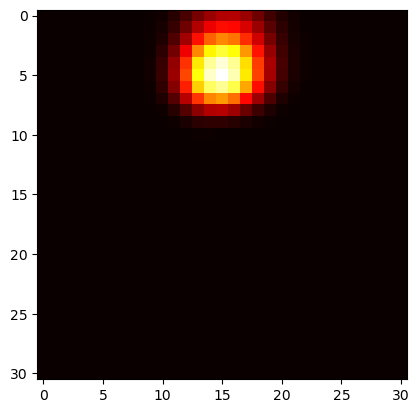

In [32]:
import matplotlib.pyplot as plt

plt.imshow(p_values, cmap='hot', interpolation='nearest')
plt.show()

In [19]:
np.min(p_values)

1.0318633767138887e-57

In [23]:
test_data1 = [1,2,2,3,3,3,4,4,5]
test_data2 = [17,18,18,19,19,19,20,20,21]

stats.ttest_ind(a=test_data2, b=test_data2, axis = 0, equal_var=False, alternative='two-sided')

TtestResult(statistic=0.0, pvalue=1.0, df=16.0)